# The Sky Team Project: Analysis

## This notebook explains what this project is, what it means, and what we did with it.

### First, some background on the name...

You might recognize our team name, "Sky Team," as being very similar to one of the world's leading airline alliances, SkyTeam. This isn't unintentional. We felt this was a great name for our project, as our mutual love of aviation and interest in exploring the massive amount of data that was collected by San Francisco Airport Commission.

### About that data...

It's located [here](https://catalog.data.gov/dataset/air-traffic-passenger-statistics), and it's from San Francisco International Airport. The City of San Francisco, through its SFO Airport Commission, is responsible for the data we used.

### What's the point?

What we have here is an aviation enthusiast (or data scientist's) dream. We have over 17,500 rows of data, spanning over 12 years! In SFO alone, the airline industry has changed so much over that period of time that there will be plenty of observable trends derived from the metrics gleaned by SFOAC in this databank. There's even many airlines on that list who (sadly) no longer grace our skies...the consolidation of the airline industry from 2009-2015 has really left its mark.

### Import sqlite3, Pandas, and the ipython-sql (%sql) Jupyter extension...and a few more.

Like all great Jupyter notebooks, our project revolves around several Python modules that were essential for the proper excecution of our code. These were SQLite, Pandas, Numpy, MatPlotLib, Seaborn, GeoPy, Basemap, rgb2hex, Polygon, ScalarMappable, Colorbarbase, and Math.

In [4]:
# Here are all the modules we used.
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
import matplotlib as mpl
import math

%load_ext sql

### Connecting to the database

In [5]:
%sql sqlite:///airpassenger.db

'Connected: None@airpassenger.db'

## The Terminals

As you might imagine, terminal information is a crucially important part of air travel.

In [3]:
airportterminal_rs = %sql None@airpassenger.db SELECT * FROM AIRPORTDIMENSION;
airportterminal = airportterminal_rs.DataFrame().set_index('AirportID')
airportterminal

Done.


,Terminal,BoardingArea
AirportID,,
1,Terminal 1,B
2,International,G
3,International,A
4,Terminal 3,E
5,Terminal 1,C
6,Terminal 1,A
7,Terminal 3,F
8,Other,Other
9,Terminal 2,D


In [ ]:
# I was thinking here would be a good place to show the utilization of terminals over the entire dataset, maybe in a histogram. However, I have had nothing but trouble doing this. I will keep trying in the meantime.

In [ ]:
# We could then show the terminal allocation from 2005-2011.

In [ ]:
# Then, we could show 2011-2017 terminal allocation.

In [13]:
"Create a histogram that shows the distribution of terminals among flights."
terminalmap = boardingarea['airportterminal']
plt.hist(age, alpha=.40, label='Terminal', bins=6, ec="k")
plt.xlabel('Terminal Number')
plt.ylabel('Number of Passengers')
plt.title('Distribution of Passengers Among Terminals')

# Add legend
plt.legend()

# Show the figure
plt.show()

NameError: name 'age' is not defined

In [4]:
passenger_rs = %sql None@airpassenger.db SELECT * FROM PASSENGERFACT;
passenger = passenger_rs.DataFrame().set_index('EntryID')
passenger

Done.


,OperatingID,AirportID,GeoID,ActivityID,TimeID,PublishedID,PassengerCount
EntryID,,,,,,,
1,1,1,1,1,1,1,27271
2,1,1,1,2,1,1,29131
3,1,1,1,3,1,1,5415
4,1,1,1,1,2,1,27472
5,1,1,1,2,2,1,26535
6,1,1,1,3,2,1,5712
7,1,1,1,1,3,1,17341
8,1,1,1,2,3,1,18541
9,1,1,1,3,3,1,4412


In [ ]:
# I was then hoping to create a bar chart showing the distribution of places the flights went to.

In [ ]:
# We could then do one that shows what % of the flights were "Low Fare."

In [ ]:
# Then after that, a pie chart showing the % breakdown of flights enplaned, in-transit, and deplaned.

In [ ]:
# Once we have that, it should be relatively easier to make one for 2005-2011.

In [ ]:
# Then, the same for 2011-2017. This will help emphasize the industry shift. I will write descriptions in Markdown for all of them.

In [10]:
%%sql
select terminal, sum(passengercount)
from AIRPORTDIMENSION JOIN PASSENGERFACT ON (AIRPORTDIMENSION.AirportID = PASSENGERFACT.AirportID)
group by terminal;

Done.


Terminal,sum(passengercount)
International,1805337136
Other,228
Terminal 1,407671524
Terminal 2,48724642
Terminal 3,559782518


In [17]:
airportterminal_rs = %sql None@airpassenger.db select ActivityType, sum(passengercount) from ACTIVITYDIMENSION JOIN PASSENGERFACT ON (ACTIVITYDIMENSION.ActivityID = PASSENGERFACT.ActivityID) group by ActivityType;
airportterminal = airportterminal_rs.DataFrame()
airportterminal


Done.


,ActivityType,sum(passengercount)
0,Deplaned,1412383233
1,Enplaned,1399418473
2,Thru / Transit,9714342


In [ ]:
%%sql
select ActivityType, sum(passengercount)
from ACTIVITYDIMENSION JOIN PASSENGERFACT ON (ACTIVITYDIMENSION.ActivityID = PASSENGERFACT.ActivityID)
group by ActivityType;

In [ ]:
ax = sns.barplot(y)

In [ ]:
# Lastly, a histogram of passenger volumes by -year would be helpful. Since there are so many years, that should be granular enough.

# Once I know how to do this, it would be good to choose date ranges that seperate passenger volumes by season - so we can see the busiest times/years to fly, and compare them.

# It would also be good to make a histogram of UNIQUE Airlines - so we can see the consolidation that took place with the mergers and eliminated a lot of choice in the market over this timespan.

Done.


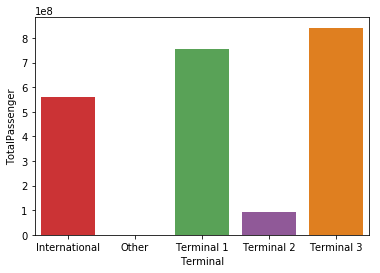

In [24]:
airportterminal = %sql select AIRPORTDIMENSION.terminal, sum(passengercount) as TotalPassenger from AIRPORTDIMENSION JOIN flightdata ON (flightdata.Terminal=AIRPORTDIMENSION.Terminal) group by AIRPORTDIMENSION.terminal;
airportterminal_df = airportterminal.DataFrame()
airportterminal_df
ax = sns.barplot(y=airportterminal_df['TotalPassenger'], x=airportterminal_df['Terminal'], data=airportterminal_df,palette='Set1')
plt.show()

In [26]:
import datetime as dt
Passengeryear_rs = %sql select ActivityPeriod, sum(passengercount) as TotalPassenger from TIMEDIMENSION JOIN PASSENGERFACT ON (TIMEDIMENSION.TimeID = PASSENGERFACT.TimeID) group by ActivityPeriod;
Passengeryear = Passengeryear_rs.DataFrame()
Passengeryear['ActivityPeriod'] = Passengeryear['ActivityPeriod'].astype('str')

Passengeryear['Date'] = Passengeryear['ActivityPeriod'].apply(lambda x: dt.datetime.strptime(x,'%Y%m'))

Passengeryear.set_index('Date')

Done.


,ActivityPeriod,TotalPassenger
Date,,
2005-07-01,200507,57049182
2005-08-01,200508,56438067
2005-09-01,200509,47851491
2005-10-01,200510,47985315
2005-11-01,200511,44284782
2005-12-01,200512,46750485
2006-01-01,200601,45241683
2006-02-01,200602,39399486
2006-03-01,200603,47879376


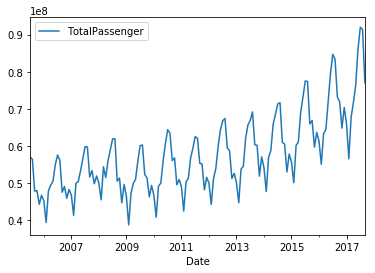

In [28]:
%matplotlib inline
Passengeryear = Passengeryear.set_index('Date')
Passengeryear.plot()

### We will merge the operating airport dimension  with another dataset

In [15]:
#taking the hosted csv file and creating the air-traffic-landings-statistics.csv
url = 'https://data.sfgov.org/api/views/fpux-q53t/rows.csv?accessType=DOWNLOAD'
from urllib.request import urlretrieve
urlretrieve(url, 'air-traffic-landings-statistics.csv')

('air-traffic-landings-statistics.csv',
 <http.client.HTTPMessage at 0x1a108200b8>)

In [16]:
import pandas as pd
# importing air-traffic-landings-statistics.csv into table called data
data = pd.read_csv('air-traffic-landings-statistics.csv')
data.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight
0,200507,ABX Air,GB,ABX Air,GB,Domestic,US,Freighter,Narrow Body,McDonnell Douglas,DC-9,30,40,4066000
1,200507,ABX Air,GB,ABX Air,GB,Domestic,US,Freighter,Narrow Body,McDonnell Douglas,DC-9,41,1,102000
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,2,396000
3,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,167,37408000
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Passenger,Wide Body,Boeing,767,333,1,320000


/* *** Transfering OPERATINGAIRDIMENSION into dataframe  *** */

In [19]:
operatingairline_rs = %sql None@airpassenger.db select * from OPERATINGAIRDIMENSION;
operatingairline = operatingairline_rs.DataFrame().set_index('OperatingID')


Done.


In [20]:
#merging two tables together which is operatingairline and data
airlanding = pd.merge(left=operatingairline,right=data,left_on='OperatingIATA',right_on='Operating Airline IATA Code')
airlanding.head()

,OperatingAirlineIdentifier,OperatingIATA,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight
0,ATA Airlines,TZ,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,2,396000
1,ATA Airlines,TZ,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,167,37408000
2,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,737,800,1,146300
3,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,3,594000
4,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,159,35616000


In [12]:
#deleting all rows that have Landing Aircraft Type is Freighter
airline = airlanding[airlanding['Landing Aircraft Type'] != "Freighter"]
airline.head()

,OperatingAirlineIdentifier,OperatingIATA,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight
0,ATA Airlines,TZ,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,2,396000
1,ATA Airlines,TZ,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,167,37408000
2,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,737,800,1,146300
3,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,3,594000
4,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,159,35616000


In [21]:
#checking to see which Aircraft Manufacturer is operated the most
airline['Aircraft Manufacturer'].value_counts()

Boeing               13820
Airbus                5655
Bombardier            1133
Embraer                586
McDonnell Douglas      473
DeHavilland             41
Lockheed                 5
Name: Aircraft Manufacturer, dtype: int64

In [22]:
#Counting which airlines make the most landing
Landing = airline.groupby(by='OperatingAirlineIdentifier')['Landing Count'].sum().sort_values()
Landing

OperatingAirlineIdentifier
Xtra Airways                                 1
World Airways                                3
Atlas Air, Inc                               7
Miami Air International                     11
BelAir Airlines                             33
Thomas Cook Airlines                        40
Finnair                                     52
Air Pacific Limited dba Fiji Airways        79
Allegiant Air                               88
Icelandair                                 119
Jet Airways                                181
XL Airways France                          204
Republic Airlines                          285
Spirit Airlines                            314
Independence Air                           318
WOW Air                                    364
Air India Limited                          428
Air Berlin                                 505
Volaris Airlines                           509
Atlantic Southeast Airlines                585
Air Canada Jazz                  